## Fitting dynamical models with priors which are conditioned on functional anchors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondLowRankMatrixDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = 100
n_modes = 5
n_smps = 2000
neural_noise_std = .2 # Amount of noise we add to neural activity

## Here we define functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
def visualize_low_rank_matrix_modes(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    l_dists = d.l_mode_dists
    r_dists = d.r_mode_dists
    
    n_modes = len(l_dists)
    
    plt.figure()
    
    for m_i in range(n_modes):
        
        # Plot r modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(r_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot l modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(l_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        

## Define the likelihood model we will use

In [5]:
class SubjectModel(torch.nn.Module):
    
    def __init__(self, d_x:int):
        """ Creates a SubjectModel object.
        
        Args:
            n: the dimensionality of x (which is the data we predict from)
        """
        
        super().__init__()
         
        self.d_x = d_x
        self.std = ConstantBoundedFcn(lower_bound=.01*np.ones(d_x), upper_bound=5*np.ones(d_x), init_value=np.ones(d_x))
        
    def forward(self, x: torch.Tensor, w: torch.Tensor):
        
        return cond_mn(x, w)
        
    def cond_mn(self, x: torch.Tensor, w: torch.Tensor):
        """ Computes mean given x and w.
        
        Args:
            x: neural data of shape n_smps*d_x
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            mn: mean of shape n_smps*d_y
        
        """
        return torch.matmul(x, w.t())
    
    def cond_ll(self, x: torch.Tensor, y: torch.Tensor, w: torch.Tensor):
        """ Computes conditional likelihood of y, given x and w.
        
        Args:
            x: neural data to condition on of shape n_smps*d_x
            
            y: neural data to predict of shape n_smps*d_y
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            ll: conditional likelihood of each sample, of shape n_smps
        """
        
        if len(x.shape) == 1:
            raise(NotImplementedError('Code has not been tested with a single sample. May need to check that it still computes correctly.'))
        
        d_y = y.shape[1]
        
        mn = self.cond_mn(x, w)
        std = self.std(mn)
           
        delta = y - mn
        delta_div = delta/std
        dist_sq = torch.sum(delta_div**2,1)
        
        
        ll = -.5*dist_sq
        ll -= torch.sum(torch.log(std), 1)
        ll -= .5*d_y*torch.log(torch.tensor([math.pi]))
        
        return ll

## Generate neuron properties

In [6]:
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Define true conditional prior on weights matrix

In [7]:
# Spike and slab modes

n_nodes = 20

p_l_mode_dists = [None]*n_modes
p_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.000001)
    p_l_spike_d = CondBernoulliDistribution(p_l_spike_log_prob_fcn)

    p_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_l_slab_mn_fcn[4].weight.data = 10*p_l_slab_mn_fcn[4].weight.data

    p_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_l_slab_d = CondGaussianDistribution(mn_f=p_l_slab_mn_fcn, std_f=p_l_slab_std_fcn)


    p_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_spike_d, slab_d=p_l_slab_d)
    
    
    # Setup r mode 
    p_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.0000001)
    p_r_spike_d = CondBernoulliDistribution(p_r_spike_log_prob_fcn)

    p_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_r_slab_mn_fcn[4].weight.data = 10*p_r_slab_mn_fcn[4].weight.data

    p_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_r_slab_d = CondGaussianDistribution(mn_f=p_r_slab_mn_fcn, std_f=p_r_slab_std_fcn)


    p_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_spike_d, slab_d=p_r_slab_d)
    

p = CondLowRankMatrixDistribution(l_mode_dists=p_l_mode_dists, r_mode_dists=p_r_mode_dists)

## Sample from prior on weight matrix to get true modes of the weight matrix for the subject

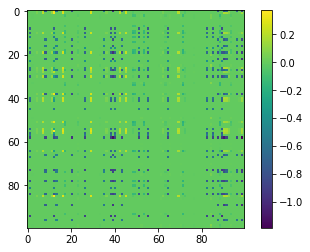

In [8]:
with torch.no_grad():
    smp = p.sample(neuron_props, neuron_props)
    w_true = p.form_matrix(smp)
    
# Show the true weight matrix
plt.imshow(w_true.detach())
plt.colorbar()

## Generate neural activity

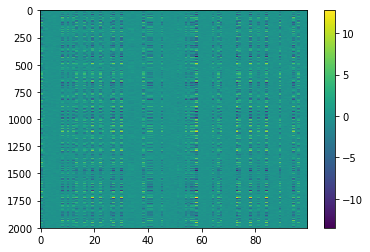

In [9]:
with torch.no_grad():
    x = torch.randn([n_smps, n_neurons])
    y_mn = torch.matmul(x, w_true.t())
    y_noise = torch.randn([n_smps, n_neurons])*neural_noise_std
    y = y_mn + y_noise
    
plt.imshow(y, aspect='auto')
plt.colorbar()

## Initialize conditional prior on weights matrix we will fit

In [10]:
class GeneralLogCondProb(torch.nn.Module):
    
    def __init__(self, n_nodes = 10):
        
        super().__init__()
        
        self.net = torch.nn.Sequential(torch.nn.Linear(2, n_nodes), torch.nn.Tanh(), torch.nn.Linear(n_nodes, n_nodes),
                                                 torch.nn.Tanh(), torch.nn.Linear(n_nodes, 1), torch.nn.LogSigmoid())
        
    def forward(self, x):
        return self.net(x).squeeze()

In [11]:
class IndLogProb(torch.nn.Module):
    
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.probs = ConstantBoundedFcn(-4*np.ones(n), np.zeros(n), -.5*np.ones(n))
    
    def forward(self, x):
        place_holder_input = torch.zeros(1)
        return self.probs(place_holder_input).squeeze()
        

In [12]:
class IndMean(torch.nn.Module):
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.mn = ConstantRealFcn(.1*np.ones(n))
        
    def forward(self, x):
        x = x.squeeze()
        place_holder_input = torch.zeros(1)
        full_mn = self.mn(place_holder_input).t()
        return full_mn[x, :]

In [13]:
class IndStd(torch.nn.Module):
    
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.stds = ConstantBoundedFcn(0*np.ones(n), 10*np.ones(n), .1*np.ones(n))
    
    def forward(self, x):
        x = x.squeeze()
        place_holder_input = torch.zeros(1)
        full_std = self.stds(place_holder_input).t()
        return full_std[x, :]

## Define p we use for fitting

In [14]:
# Spike and slab modes

p_f_l_mode_dists = [None]*n_modes
p_f_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_f_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.000001)
    p_f_l_spike_d = CondBernoulliDistribution(p_f_l_spike_log_prob_fcn)

    p_f_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_l_slab_mn_fcn[4].weight.data = 10*p_f_l_slab_mn_fcn[4].weight.data

    p_f_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_l_slab_d = CondGaussianDistribution(mn_f=p_f_l_slab_mn_fcn, std_f=p_f_l_slab_std_fcn)


    p_f_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_f_l_spike_d, slab_d=p_f_l_slab_d)
    
    
    # Setup r mode 
    p_f_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.0000001)
    p_f_r_spike_d = CondBernoulliDistribution(p_f_r_spike_log_prob_fcn)

    p_f_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_r_slab_mn_fcn[4].weight.data = 10*p_f_r_slab_mn_fcn[4].weight.data

    p_f_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_r_slab_d = CondGaussianDistribution(mn_f=p_f_r_slab_mn_fcn, std_f=p_f_r_slab_std_fcn)


    p_f_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_f_r_spike_d, slab_d=p_f_r_slab_d)
    

p_f = CondLowRankMatrixDistribution(l_mode_dists=p_f_l_mode_dists, r_mode_dists=p_f_r_mode_dists)

## Define q we use for fitting

In [15]:
# Spike and slab modes

q_l_mode_dists = [None]*n_modes
q_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    q_l_spike_log_prob_fcn = IndLogProb(n_neurons)
    q_l_spike_d = CondBernoulliDistribution(q_l_spike_log_prob_fcn)

    q_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    #q_l_slab_mn_fcn = IndMean(n_neurons)
        
        
    q_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.25))
    #q_l_slab_std_fcn = IndStd(n_neurons)
    
    q_l_slab_d = CondGaussianDistribution(mn_f=q_l_slab_mn_fcn, std_f=q_l_slab_std_fcn)


    q_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_l_spike_d, slab_d=q_l_slab_d)
    
    # Setup r mode 
    q_r_spike_log_prob_fcn = IndLogProb(n_neurons)
    q_r_spike_d = CondBernoulliDistribution(q_r_spike_log_prob_fcn)

    q_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    #q_r_slab_mn_fcn = IndMean(n_neurons)
    
    q_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                          init_value=np.asarray(.25))
    #q_r_slab_std_fcn = IndStd(n_neurons)
    
    q_r_slab_d = CondGaussianDistribution(mn_f=q_r_slab_mn_fcn, std_f=q_r_slab_std_fcn)


    q_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=q_r_spike_d, slab_d=q_r_slab_d)

q = CondLowRankMatrixDistribution(l_mode_dists=q_l_mode_dists, r_mode_dists=q_r_mode_dists)

## Perform fitting

In [16]:
s = SubjectModel(n_neurons)

In [17]:
r_params = list(itertools.chain(s.parameters(), q.r_params(), p_f.r_params(), p_f.s_params()))

s_params = list(itertools.chain(q.s_params()))

r_optim = torch.optim.Adam(r_params, lr=.002)
s_optim = torch.optim.Adam(s_params, lr=.002)

In [42]:
n_its = 40000
update_int = 100
n_inf_smps = 10

c_l = torch.zeros(n_modes)
c_r = torch.zeros(n_modes)
alpha = .9

for i in range(n_its):
    # Don't need to calculate gradients for s_params yet
    for s_p in s_params:
        s_p.requires_grad = False
    
    # Sample q
    smp = [q.sample(neuron_props, neuron_props) for j in range(n_inf_smps)]
    w = [q.form_matrix(smp_j) for smp_j in smp]
    
    # Calculate gradients we can use the reparamaterization trick for
    r_optim.zero_grad()
    nlls = torch.zeros(n_inf_smps)
    q_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    q_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    
    for j in range(n_inf_smps):
        nlls[j] = -1*torch.sum(s.cond_ll(x, y, w[j]))
        
        q_l_lp, q_r_lp = q.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        q_l_mode_log_probs[j, :] = torch.sum(q_l_lp, dim=0)
        q_r_mode_log_probs[j, :] = torch.sum(q_r_lp, dim=0)
        
        p_l_lp, p_r_lp = p_f.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        p_l_mode_log_probs[j, :] = torch.sum(p_l_lp, dim=0)
        p_r_mode_log_probs[j, :] = torch.sum(p_r_lp, dim=0)
        
    neg_elbo = torch.sum(nlls) + torch.sum(q_l_lp) + torch.sum(q_r_lp) - torch.sum(p_l_lp) - torch.sum(p_r_lp)
    
    neg_elbo.backward(retain_graph=True)
    
    # Set things up to calculate gradients for parameters we need score function for
    for s_p in s_params:
        s_p.requires_grad = True
    for r_p in r_params:
        r_p.requires_grad = False
        
    with torch.no_grad():
        # Calculate raw learning signals
        learning_sigs_l = torch.zeros(n_inf_smps, n_modes)
        learning_sigs_r = torch.zeros(n_inf_smps, n_modes)
        for j in range(n_inf_smps): # Can use broadcastin instead of loops here
            for k in range(n_modes):
                learning_sigs_l[j, k] = nlls[j] + q_l_lp[j, k] - p_l_lp[j, k]
                learning_sigs_r[j, k] = nlls[j] + q_r_lp[j, k] - p_r_lp[j, k]
        
        # Apply multi-sample baseline correction
        for j in range(n_inf_smps):
            for k in range(n_modes):
                learning_sigs_l[j,k] = learning_sigs_l[j, k] - (torch.sum(learning_sigs_l[:, k]) - learning_sigs_l[j, k])/(n_inf_smps-1)
                learning_sigs_r[j,k] = learning_sigs_r[j, k] - (torch.sum(learning_sigs_r[:, k]) - learning_sigs_r[j, k])/(n_inf_smps-1)
            
    s_optim.zero_grad()
    o_s = 0
    for j in range(n_inf_smps):
        for k in range(n_modes):
            smp_l = smp[j][0]
            smp_r = smp[j][1]
            o_s += learning_sigs_l[j,k]*torch.sum(q.l_mode_dists[k].log_prob(neuron_props, smp_l[k]))
            o_s += learning_sigs_r[j,k]*torch.sum(q.r_mode_dists[k].log_prob(neuron_props, smp_r[k]))
    
    o_s.backward()
        
    for r_p in r_params:
        r_p.requires_grad = True   
    
    # Actually update parameters here
    r_optim.step()
    s_optim.step()
    
    # Update parameters 
    if i % update_int == 0:
        neg_elbo_r = neg_elbo.detach().numpy()
        o_s_r = o_s.detach().numpy()
        print('It: ' + str(i) + ', neg_elbo: ' + str(neg_elbo_r) + ' o_s: ' + str(o_s))
    

It: 0, neg_elbo: 278784.34 o_s: tensor(2.5508e+08, grad_fn=<AddBackward0>)
It: 100, neg_elbo: 216614.34 o_s: tensor(2.0185e+08, grad_fn=<AddBackward0>)
It: 200, neg_elbo: 258074.9 o_s: tensor(2.3458e+08, grad_fn=<AddBackward0>)
It: 300, neg_elbo: 243207.42 o_s: tensor(2.2189e+08, grad_fn=<AddBackward0>)
It: 400, neg_elbo: 243608.31 o_s: tensor(2.2374e+08, grad_fn=<AddBackward0>)
It: 500, neg_elbo: 207107.75 o_s: tensor(1.9104e+08, grad_fn=<AddBackward0>)
It: 600, neg_elbo: 223711.03 o_s: tensor(2.0468e+08, grad_fn=<AddBackward0>)
It: 700, neg_elbo: 223830.44 o_s: tensor(2.0743e+08, grad_fn=<AddBackward0>)
It: 800, neg_elbo: 227953.98 o_s: tensor(2.1099e+08, grad_fn=<AddBackward0>)
It: 900, neg_elbo: 206628.97 o_s: tensor(1.9214e+08, grad_fn=<AddBackward0>)
It: 1000, neg_elbo: 235932.27 o_s: tensor(2.1936e+08, grad_fn=<AddBackward0>)
It: 1100, neg_elbo: 233563.48 o_s: tensor(2.1647e+08, grad_fn=<AddBackward0>)
It: 1200, neg_elbo: 237706.95 o_s: tensor(2.2178e+08, grad_fn=<AddBackward0>)

KeyboardInterrupt: 

In [43]:
smp_i = q.sample(neuron_props, neuron_props)
#smp_i = q.sample(neuron_inds, neuron_inds)
w_i = q.form_matrix(smp_i)

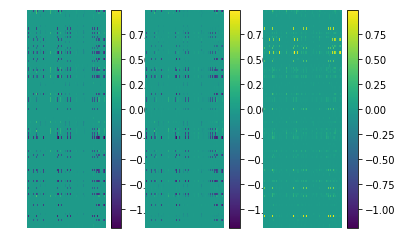

In [44]:
w_n = w_true.detach().numpy()
w_i_n = w_i.detach().numpy()
cmp_n_mats([w_n, w_i_n, np.abs(w_n - w_i_n)], show_colorbars=True)

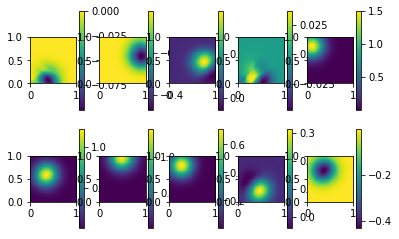

In [45]:
visualize_low_rank_matrix_modes(p)

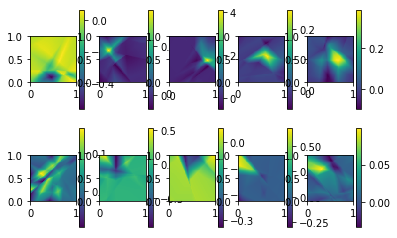

In [46]:
visualize_low_rank_matrix_modes(p_f)

In [47]:
torch.exp(p.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props)) - torch.exp(p_f.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props))

tensor([-0.5916, -0.5573, -0.8851, -0.6764, -0.7361, -0.6215, -0.6682, -0.9092,
        -0.6486, -0.6676, -0.6991, -0.8615, -0.8133, -0.4392, -0.7400, -0.4846,
        -0.9116, -0.7584, -0.7213, -0.6270, -0.7269, -0.5328, -0.3899, -0.4665,
        -0.5612, -0.2486, -0.3679, -0.7896, -0.7246, -0.8741, -0.6730, -0.4893,
        -0.3339, -0.7642, -0.3238, -0.4368, -0.7457, -0.2103, -0.6152, -0.5326,
        -0.5144, -0.7117, -0.8709, -0.5664, -0.2585, -0.9168, -0.3874, -0.5564,
        -0.5925, -0.1128, -0.2492, -0.6221, -0.0966,  0.1741, -0.5895, -0.3872,
        -0.6735, -0.4619, -0.3369, -0.3651, -0.0963, -0.6811, -0.7059,  0.0499,
        -0.7062, -0.2570, -0.5307, -0.8846, -0.4669, -0.9245, -0.3229, -0.0262,
        -0.5257, -0.6032, -0.7040, -0.5533, -0.8960, -0.5269, -0.6761, -0.6123,
        -0.9300, -0.5022, -0.4941, -0.4910, -0.6788, -0.3544, -0.8965, -0.7388,
        -0.2180, -0.4690, -0.8614, -0.6792, -0.7539, -0.1014, -0.4093, -0.4606,
        -0.6918, -0.6275, -0.8725, -0.36

In [50]:
torch.exp(p_f.r_mode_dists[0].spike_d.log_prob_fcn(neuron_props))

tensor([0.5917, 0.5576, 0.9876, 0.9391, 0.7513, 0.6267, 0.7502, 0.9116, 0.6486,
        0.8280, 0.7003, 0.9046, 0.8411, 0.4392, 0.7405, 0.5348, 0.9154, 0.9469,
        0.7367, 0.6274, 0.7272, 0.6427, 0.3899, 0.6175, 0.5754, 0.6516, 0.3681,
        0.7914, 0.7756, 0.8755, 0.6732, 0.7254, 0.5698, 0.8959, 0.4361, 0.4368,
        0.7542, 0.5060, 0.6153, 0.5329, 0.5158, 0.7130, 0.8724, 0.5664, 0.2585,
        0.9199, 0.3874, 0.5601, 0.5988, 0.7351, 0.2492, 0.6260, 0.6632, 0.6838,
        0.5910, 0.3873, 0.6746, 0.4631, 0.3369, 0.3651, 0.4559, 0.8121, 0.7093,
        0.4743, 0.7096, 0.5902, 0.5307, 0.8868, 0.5640, 0.9302, 0.6422, 0.7305,
        0.5273, 0.6032, 0.7042, 0.9088, 0.9858, 0.5269, 0.6764, 0.6123, 0.9584,
        0.5145, 0.5005, 0.5132, 0.6789, 0.3545, 0.9874, 0.7389, 0.6546, 0.4690,
        0.8628, 0.6793, 0.7567, 0.7504, 0.4093, 0.4606, 0.6919, 0.6293, 0.8775,
        0.8463])

In [36]:
for r_p in r_params:
        r_p.requires_grad = True 